## Universidade Federal do Rio Grande do Sul (UFRGS)
## Programa de Pós-Graduação em Engenharia Civil/Estruturas (PPGEC)   
## PEC00025: Introdução à Teoria de Vibrações
## Aluno: Francisco da Silva Brandão (00312120)

### *Trabalho 1: Resposta de um sistema de 1GDL submetido a uma excitação na base: cálculo do espectro de pseudo aceleração e periodogramas*


[1.   Objetivo ](#section_1)

[2.   Coleta do sinal de excitação](#section_2)

[3.   Características do sistema de 1GDL](#section_3)

[4.   Cálculo do espectro de pseudo aceleração](#section_4)

[5.   Cálculo do periodograma de input](#section_5)

[6.   Cálculo do periodograma de output](#section_6)

[7.   Considerações finais](#section_7) 

[8.   Referências](#section_8) 


In [8]:
# Importando os mudulos Python necessários a esta análise

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from MRPy import MRPy

## 1. Objetivo <a name="section_1"></a> 

Este trabalho objetiva calcular a resposta de um sistema de um grau de liberdade (1GDL) submetido a uma excitação na base, como se faz em análise sísmica, através de seu espectro de pseudo aceleração e também estimar os periodogramas do sinal de entrada (acelerograma) e de saída (resposta para uma frequência específica). Para isso, foi utilizada a solução numérica tendo como técnica de integração, a integral de Duhamel, esta que é implementada no  **MRPy- Multivariate Random Processes with Python**, uma rotina computacional em Python para análise dinâmica de sistemas estruturais, desenvolvida pelo Prof. Marcelo M. Rocha, Dr.techn.[(ORCID)](https://orcid.org/0000-0001-5640-1020) 


## 2. Coleta do sinal de excitação  <a name="section_2"></a> 

O sinal utilizado como excitação de base no sistema de 1GDL foi coletado utilizando-se o aplicativo de celular iNVH versão 2.2.1 distribuído pela Bosch [(iNVH)](https://play.google.com/store/apps/details?id=com.bosch.nvh_analysis&hl=it). Este aplicativo permite medição rápida de ruídos e vibrações, sendo que para vibração, limita-se à frequência de 100 Hz.
A estrutura utilizada para medição foi um trampolim de jumping como mostra a  Figura 1, no qual o celular foi posicionado sobre a tela, colado com uma fita adesiva para não se deslocar e em seguida, este autor, deu um pequeno salto sobre o trampolim, causando assim a pertubação.  <br/>
O aplicativo mediu a vibração gerada pelo impulso até a estrutua voltar novamente ao repouso, pois trata-se de um sistema amortecido, como se pode constatar pelas várias molas que prendem a tela. 

<img src="data1/fig1.jpeg" width="400px"/>
<img src="data1/fig2.jpeg" width="400px"/>

<center> Figura 1: Estrutura utilizada para gerar o sinal de excitação de base


 O sinal foi coletado nos três eixos *(x,y,z)* e possui uma duração de 30s cada acelerograma. Os três gráficos de cada componente são plotados a seguir, onde Acc1 representa a componente $x$, Acc2 a componente $y$ e Acc3 a componente $z$.

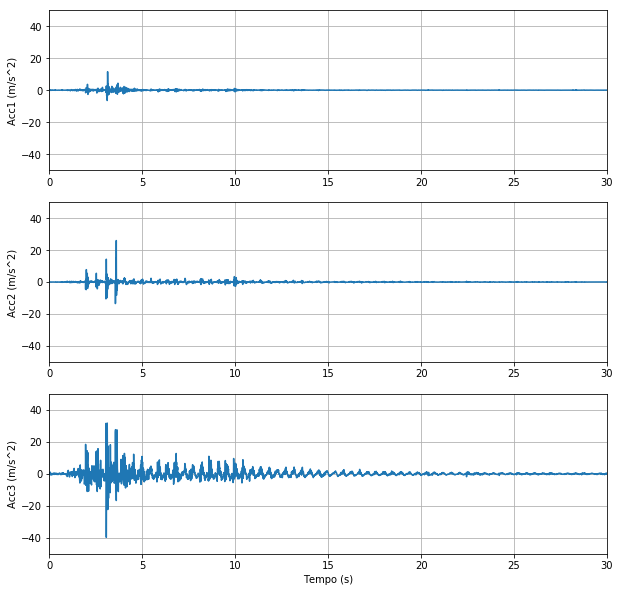

In [9]:
signal = MRPy.from_file('data1/sig1', form='invh').zero_mean()
t    = signal.t_axis()

plt.figure(2, figsize=(10, 10), clear=True)

for kX, acc in enumerate(signal):
    
    plt.subplot(3, 1 ,kX+1)
    plt.plot(t, acc)

    plt.xlim(0, signal.Td);   
    plt.ylim(-50, 50);
    plt.ylabel('Acc{0} (m/s^2)'.format(kX+1)) 

    plt.grid(True) 

plt.xlabel('Tempo (s)');

Neste trabalho será utilizada apenas a componente $z$, pois é a que apresenta maiores amplitudes de aceleração e também é a que mais se adequa ao tipo de excitação aqui proposto, ou seja, na direção vertical, como visto na Figura 2 que traz um esquema do sistema de 1GDL.

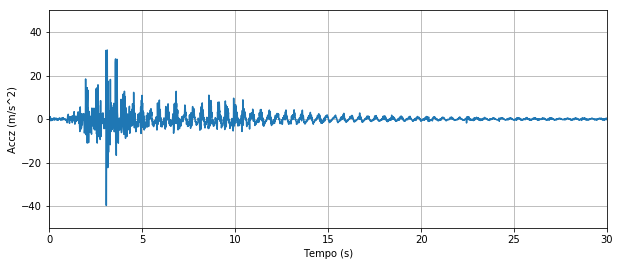

In [10]:
accz = MRPy(signal[2], signal.fs)  
t  = accz.t_axis()

plt.figure(3, figsize=(10, 4), clear=True)
plt.plot(t, accz[0])

plt.xlim(0, accz.Td);  plt.xlabel('Tempo (s)') 
plt.ylim(-50, 50);   plt.ylabel('Accz (m/s^2)') 

plt.grid(True) 

## 3. Características do sistema de 1GDL  <a name="section_3"></a> 

O Sistema de 1GDL deste trabalho é fixado em uma superfície horizontal e possui uma massa $m$ acoplada a uma mola de rigidez $k$ e a um amortecedor $c$. Ao nível da superfície tem-se $a_G(t)$ que representa a excitação de base do sistema, ou seja, a excitação sísmica. Na Figura 2 tem-se uma ilustração do sistema.

<img src="data1/gdl.jpg" width="400px"/>

<center>Figura 2: Sistema de 1GDL submetido a excitação de base

Para este trabalho, escolheu-se uma massa de $1kg$, amortecimento de $0.05$ (de acordo com a ABNT NBR 15421), período estimado em $10s$ sendo que a variação arbitrada foi de $0.1s$ a $10s$, totalizando 100 pontos e as condições iniciais de $u_0$ e $v_0$ iguais a $0$.

In [11]:
m  = 1                            # Massa dos sitema =1 kg
zt = 0.05                         # Amortecimento
Tn = np.linspace(0.1, 10, 100)    # Período estimado = 10 s 
fn = 1/Tn                         # Frequência natural do sistema em Hz
u0 = 0.                           # Deslocamento inicial
v0 = 0.                           # Velocidade inicial

## 4. Cálculo do espectro de pseudo aceleração <a name="section_4"></a> 

Utilizando o algorítmo da Integral de Duhamel foi calculado primeiramente o deslocamento $ u(t)$ para cada uma das frequências naturais do sistema, obtidas pela relação $fn = 1/Tn $ com $Tn$ variando de $0.1s$ a $10s$. Em cada uma destas frequências utilizandas (obtidas pela variação de $Tn$) existe um pico de deslocamento $u_p$, e cada um destes picos foi explicitado e armazenado em um vetor. A seguir é plotado o gráfico com os picos dos deslocamentos em função do período.

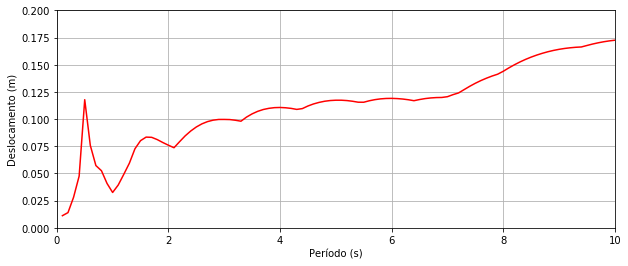

In [12]:
umax = np.zeros(fn.shape)

for k, f in enumerate(fn):
    u = accz.sdof_Duhamel(f, zt, u0, v0)/m
    umax[k] = u.max()
    
plt.figure(5, figsize=(10, 4), clear=True)
plt.plot(Tn, umax, 'r')

plt.xlim(0, Tn[-1]);        plt.xlabel('Período (s)') 
plt.ylim(0, 0.2);  plt.ylabel('Deslocamento (m)') 

plt.grid(True) 

A partir do gráfico anterior com os deslocamentos máximos, calcula-se o espectro de pseudo aceleração do sistema através da relação $a_p = \omega^{2}u_P$, o qual é mostrado a seguir.






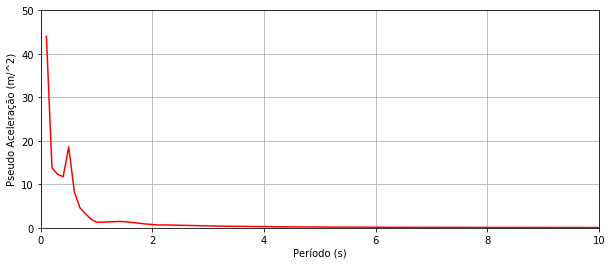

In [13]:
spa = ((2*np.pi*fn)**2)*umax
plt.figure(6, figsize=(10, 4), clear=True)
plt.plot(Tn, spa, 'r')

plt.xlim(0, 10);        plt.xlabel('Período (s)') 
plt.ylim(0, 50);  plt.ylabel('Pseudo Aceleração (m/^2)') 

plt.grid(True) 

## 5. Cálculo do periodograma de input  <a name="section_5"></a> 

Calcula-se o periodograma do sinal utilizado para excitar o sistema de 1GDL deste trabalho (o acelerograma na vertical, accz) e para isto, primeiro plota-se novamente o sinal accz e logo abaixo o seu periodograma.
    

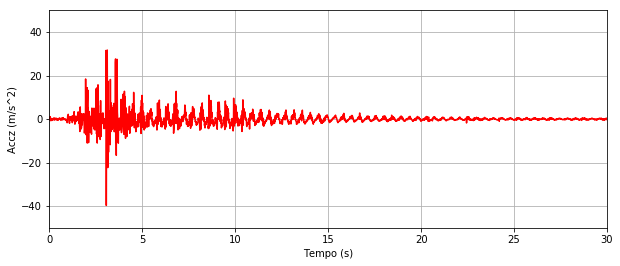

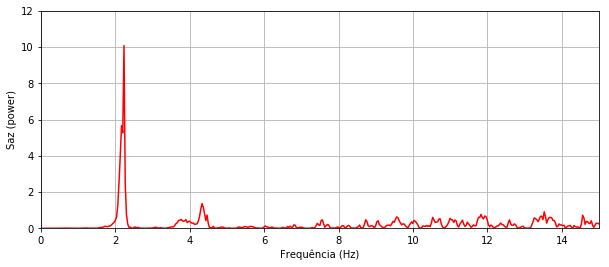

In [14]:
# Sinal da componente do acelerômetro em z- accz

data = MRPy.from_file('data1/sig1', form='invh').zero_mean()
accz   = MRPy(data[2], data.fs)
t    = accz.t_axis()

plt.figure(7, figsize=(10, 4), clear=True)
plt.plot(t, accz[0], 'r')

plt.xlim(0, accz.Td);  plt.xlabel('Tempo (s)') 
plt.ylim(-50, 50);   plt.ylabel('Accz (m/s^2)') 

plt.grid(True) 

# Cálculo do periodograma de accz

Saz, fs = accz.periodogram()
f       = accz.f_axis()

plt.figure(8, figsize=(10, 4), clear=True)
plt.plot(f, Saz[0],'r' )

plt.xlim(0, 15);   plt.xlabel('Frequência (Hz)') 
plt.ylim(0,  12);   plt.ylabel('Saz (power)') 

plt.grid(True)

Como se pode observar neste periodograma, existe uma forte densidade de energia em torno de 2Hz, indicando que este valor é a frequência dominante no sinal e que a frequência natural de vibração do sistema de 1GDL deste trabalho, pode estar próxima a este valor.

## 6. Cálculo do periodograma de output  <a name="section_6"></a> 

Por fim, calcula-se o periodograma da resposta da estrutura, para isto escolheu-se um valor de frequência fixo, neste caso de 2Hz, que é a frequência dominante no sinal de input e que pode estar próxima do valor da frequência natural de vibração do sistema deste trabalho.  
Calcula-se primeiramente a resposta, utilizando a Integral de Duhamel, em termos do deslocamento para a frequência escolhida e em seguida o periodograma para a mesma frequência.

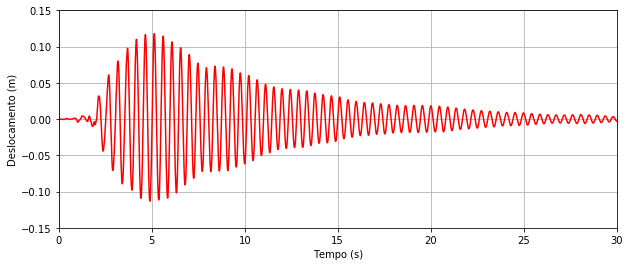

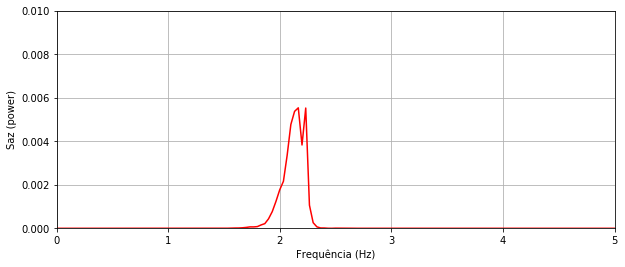

In [15]:
# Parâmetros de entrada na Integral de Duhamel

m  = 1                            # Massa dos sitema =1 kg
zt = 0.05                         # Amortecimento
fns = 2                           # Frequência natural do sistema em Hz, escolhida a partir do periodograma de input
u0 = 0.                           # Deslocamento inicial
v0 = 0.                           # Velocidade inicial

# Cálculo da resposta "u" para 2Hz pela Integral de Duhamel

u_DH = accz.sdof_Duhamel(fns, zt, u0, v0)/m

plt.figure(9, figsize=(10, 4), clear=True)
plt.plot(t, u_DH[0], 'r')
plt.xlim(0, accz.Td); plt.xlabel('Tempo (s)')
plt.ylim(-0.15, 0.15); plt.ylabel('Deslocamento (m)')
plt.grid(True)


# Cálculo do periodograma da resposta de "u_DH" para 2Hz

Saz, fs = u_DH .periodogram()
f       = u_DH .f_axis()

plt.figure(10, figsize=(10, 4), clear=True)
plt.plot(f, Saz[0],'r' )

plt.xlim(0, 5);   plt.xlabel('Frequência (Hz)') 
plt.ylim(0,  0.01);   plt.ylabel('Saz (power)') 

plt.grid(True)


## 7. Considerações finais <a name="section_7"></a> 

O espectro de pseudo aceleração é um gráfico que fornece, na variação do período T, o valor máximo da resposta (amplitude de aceleração) de um sistema, que no caso deste trabalho foi de 1GDL, sujeito a uma ação externa, como por exemplo, os sismos. É uma ferramenta de base em análises sísmicas.  <br/>
Neste trabalho o valor máximo da pseudo aceleração foi de $ 44,02 m/s^2$ que corresponde a $ 4,49 g$, seria no caso, um valor extremamente elevado quando se faz referência a ABNT NBR 15421, norma brasileira que trata projetos de estruturas resistentes a sismos, a qual fixa que o valor máximo da aceleração característica de projeto, correspondente à aceleração sísmica horizontal
máxima seja de $ a_g=0,15g$, ou seja,  $a=1,47 m/s^2$.  
Além do espectro de pseudo aceleração, foram calculados também os periodogramas do acelerograma vertical e da resposta do sistema, em termos de deslocamentos, para a frequência de 2Hz, esta que, de acordo com o periodograma de accz, pode estar próxima da frequência natural de vibração do sistema de 1GDL objeto deste trabalho. 

In [16]:
print (max (spa))   #valor máximo do espectro de pseudo aceleração 

44.01929594711002


## 8. Referências <a name="section_8"></a> 

ASSOCIAÇÃO BRASILEIRA DE NORMAS TÉCNICAS (ABNT). **NBR 15421**: Projeto de estruturas resistentes a sismos- procedimentos. ABNT: Rio de Janeiro, 2006.